In [380]:
import torch
import torch.nn as nn
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import time
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

In [381]:
print(torch.__version__)
# Only works with GPU due to input_size
device = "cpu"
input_window = 7 # 7 days in week
output_window = 1 # predict for the next day
BATCH_SIZE = 100
print(device)

2.2.2
cpu


In [382]:
def create_inout_sequences(input_data, input_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + output_window: i + input_window + output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

In [383]:
def get_data(data_raw, split):
    split = round(split * len(data_raw))
    train_data = data_raw[:split]
    test_data = data_raw[split:]

    train_data = train_data.cumsum()
    train_data = 2 * train_data  # Training data scaling

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_sequence = create_inout_sequences(test_data, input_window)
    test_sequence = test_sequence[:-output_window]

    return train_sequence.to(device), test_sequence.to(device)

In [384]:
# create batches from input and target sequence 
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    data_in = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return data_in, target

In [385]:
composite_df = pd.read_csv("composite_stocks.csv")
DJI_close = composite_df['DJI']
GSPC_close = composite_df['GSPC']
IXIC_close = composite_df['IXIC']

In [386]:
DJI_log_prices = np.diff(np.log(DJI_close))
GSPC_log_prices = np.diff(np.log(GSPC_close))
IXIC_log_prices = np.diff(np.log(IXIC_close))

DJI_log_prices_cumsum = DJI_log_prices.cumsum()
GSPC_log_prices_cumsum = GSPC_log_prices.cumsum()
IXIC_log_prices_cumsum = IXIC_log_prices.cumsum()

DJI_close

0       10646.150391
1       10945.750000
2       10912.410156
3       10662.009766
4       10621.349609
            ...     
5780    37385.968750
5781    37545.328125
5782    37656.519531
5783    37710.101562
5784    37689.539062
Name: DJI, Length: 5785, dtype: float64

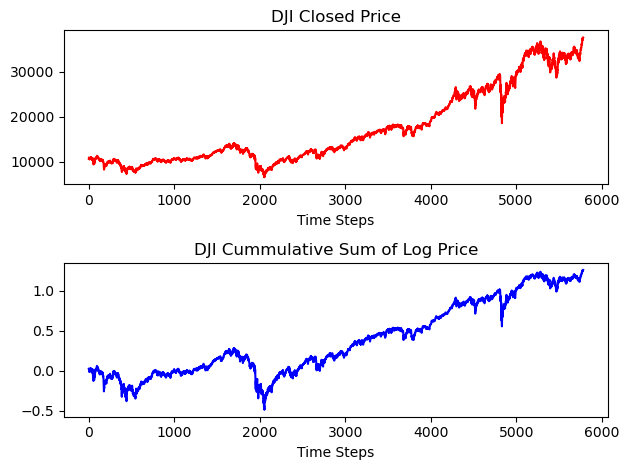

In [387]:
fig1, ax1 = plt.subplots(2, 1)
ax1[0].plot(DJI_close, color='red')
ax1[0].set_title('DJI Closed Price')
ax1[0].set_xlabel('Time Steps')

ax1[1].plot(DJI_log_prices_cumsum, color='blue')
ax1[1].set_title('DJI Cummulative Sum of Log Price')
ax1[1].set_xlabel('Time Steps')

fig1.tight_layout()

In [388]:
train_data, _ = get_data(DJI_log_prices, 0.7) # 70-30 split
_, test_data_DJI = get_data(DJI_log_prices, 0.7) # 70-30 split
_, test_data_GSPC = get_data(GSPC_log_prices, 0.7) # 70-30 split
_, test_data_IXIC = get_data(IXIC_log_prices, 0.7) # 70-30 split

In [389]:
from lstm import LSTMModel
model = LSTMModel().to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
#criterion = nn.L1Loss()

EPOCHS = 3
learning_rate = 0.00005
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [390]:
def train(train_data):
  model.train()
  total_loss = 0
  start_time = time.time()

  for batch, i in enumerate(range(0, len(train_data) - 1, BATCH_SIZE)):
    data, targets = get_batch(train_data, i, BATCH_SIZE)
    # print(f"Input data shape: {data.shape}")  # Add this line
    # print(f"Targets shape: {targets.shape}")  # Add this line
    data, targets = get_batch(train_data, i, BATCH_SIZE)
    # apply gradient descent
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, targets)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 0.7)
    optimizer.step()

    total_loss = total_loss + loss.item()
    # log_interval = int(len(train_data) / BATCH_SIZE / 5)
    log_interval = max(int(len(train_data) / BATCH_SIZE / 5), 1)
    if batch % log_interval == 0 and batch > 0:
        cur_loss = total_loss / log_interval
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5d}/{:5d} batches | '
              'lr {:02.10f} | {:5.2f} ms | '
              'loss {:5.7f}'.format(
                epoch, batch, len(train_data) // BATCH_SIZE, scheduler.get_lr()[0],
                elapsed * 1000 / log_interval,
                cur_loss))
        total_loss = 0
        start_time = time.time()


In [391]:
def evaluate(model, data_source):
    model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = model(data)
            total_loss = total_loss + len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [392]:
def predict(model, sequences):
    start_timer = time.time()
    model.eval()
    predicted_seq, real_seq = [], []
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            predicted_seq.append(output[-1].view(-1).cpu())
            real_seq.append(target[-1].view(-1).cpu())
    timed = time.time() - start_timer
    print(f"{timed} sec")

    return torch.cat(predicted_seq, 0), torch.cat(real_seq, 0)

In [393]:
for epoch in range(1, EPOCHS+1):
  epoch_start_time = time.time()
  train(train_data)

  if epoch % EPOCHS == 0:
    val_loss = evaluate(model, test_data)
    print('-' * 80)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch,
                                                                                (time.time() - epoch_start_time),
                                                                                val_loss))
    print('-' * 80)

  else:
    print('-' * 80)
    print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
    print('-' * 80)

  scheduler.step()

c:\Users\yzche\anaconda3\envs\cuda_venv\Lib\site-packages\torch\optim\lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     8/   40 batches | lr 0.0000500000 | 61.01 ms | loss -110.5271672
| epoch   1 |    16/   40 batches | lr 0.0000500000 | 52.37 ms | loss 60.4183518
| epoch   1 |    24/   40 batches | lr 0.0000500000 | 51.42 ms | loss -28.0108666
| epoch   1 |    32/   40 batches | lr 0.0000500000 | 49.99 ms | loss 207.4616899
| epoch   1 |    40/   40 batches | lr 0.0000500000 | 49.09 ms | loss 419.6689243
--------------------------------------------------------------------------------
| end of epoch   1 | time:  2.11s
--------------------------------------------------------------------------------
| epoch   2 |     8/   40 batches | lr 0.0000451250 | 58.23 ms | loss -110.5513071
| epoch   2 |    16/   40 batches | lr 0.0000451250 | 50.77 ms | loss 60.4112234
| epoch   2 |    24/   40 batches | lr 0.0000451250 | 51.63 ms | loss -28.0549403
| epoch   2 |    32/   40 batches | lr 0.0000451250 | 52.60 ms | loss 207.4450407
| epoch   2 |    40/   40 batches | lr 0.0000451250 | 47.37 ms | l

In [404]:
predicted_seq_DJI, real_seq_DJI = predict(model, test_data_DJI)
predicted_seq_GSPC, real_seq_GSPC = predict(model, test_data_GSPC)
predicted_seq_IXIC, real_seq_IXIC = predict(model, test_data_IXIC)

# _, predicted_seq_DJI = predict(model, test_data_DJI)
# _, predicted_seq_GSPC = predict(model, test_data_GSPC)
# _, predicted_seq_IXIC = predict(model, test_data_IXIC)



1.5254292488098145 sec
1.4491453170776367 sec
1.4410641193389893 sec


In [403]:
train_data, _ = get_data(DJI_log_prices, 0.7) # 70-30 split
_, test_data_DJI = get_data(DJI_log_prices, 0.7) # 70-30 split
_, test_data_GSPC = get_data(GSPC_log_prices, 0.7) # 70-30 split
_, test_data_IXIC = get_data(IXIC_log_prices, 0.7) # 70-30 split

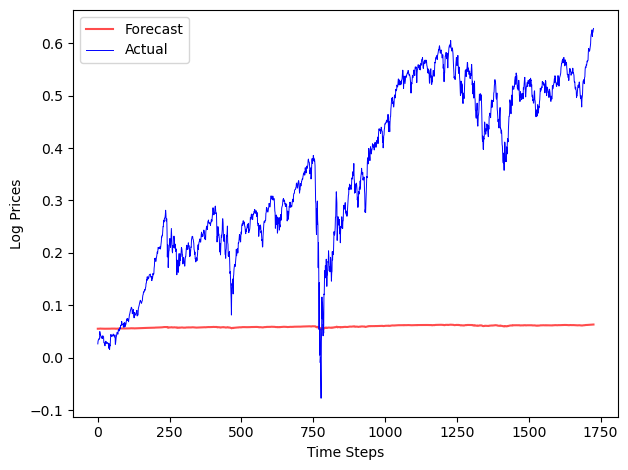

In [396]:
fig2, ax2 = plt.subplots(1, 1)

ax2.plot(predicted_seq_DJI, color='red', alpha=0.7)
ax2.plot(real_seq_DJI, color='blue', linewidth=0.7)
ax2.legend(['Forecast', 'Actual'])
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Log Prices')

fig2.tight_layout()

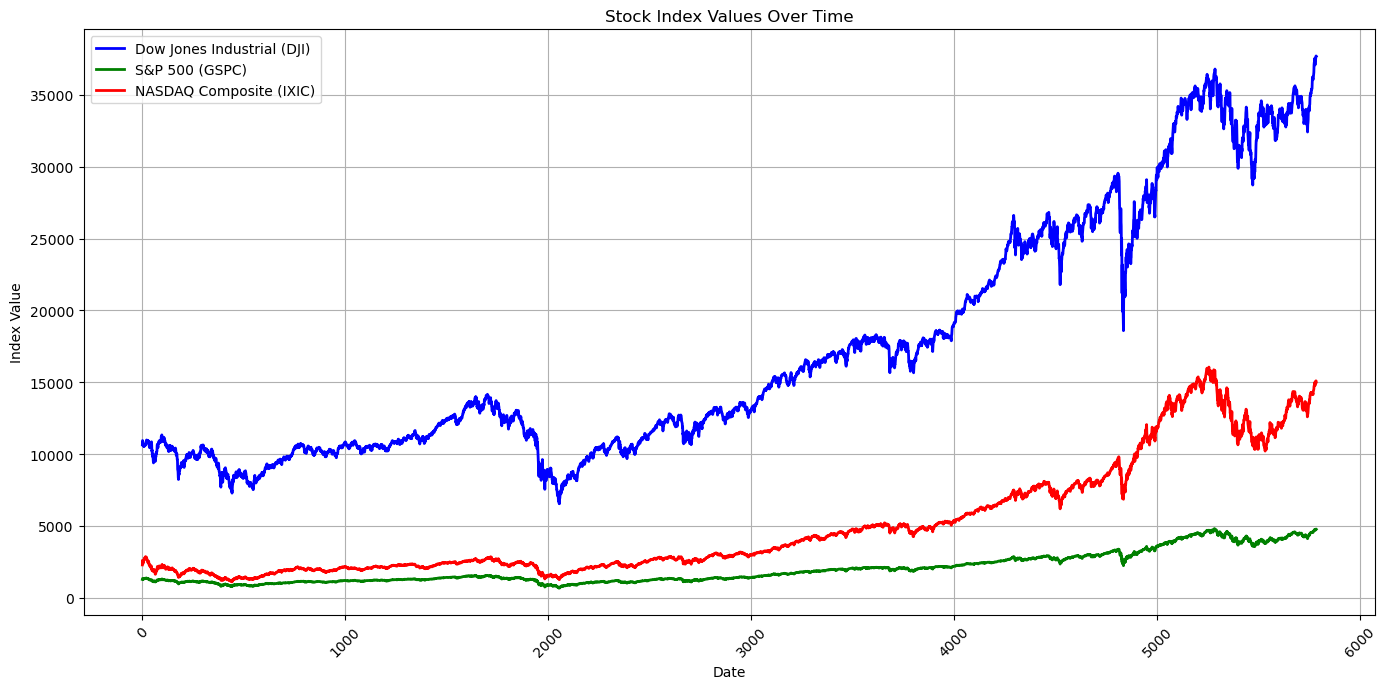

In [397]:
file_path = 'composite_stocks.csv'
data = pd.read_csv(file_path)

data['date'] = pd.to_datetime(data['date'])

# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(data['DJI'], label='Dow Jones Industrial (DJI)', color='blue', linewidth=2)
plt.plot(data['GSPC'], label='S&P 500 (GSPC)', color='green', linewidth=2)
plt.plot(data['IXIC'], label='NASDAQ Composite (IXIC)', color='red', linewidth=2)

plt.title('Stock Index Values Over Time')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [398]:
# def normalize_to_100(series):
#     return [((i / series[0]) * 100) for i in series]

# norm_predicted_dji = normalize_to_100(predicted_seq_DJI)
# norm_actual_dji = normalize_to_100(real_seq_DJI)
# norm_predicted_gspc = normalize_to_100(predicted_seq_GSPC)
# norm_actual_gspc = normalize_to_100(real_seq_GSPC)
# norm_predicted_ixic = normalize_to_100(predicted_seq_IXIC)
# norm_actual_ixic = normalize_to_100(real_seq_IXIC)

def condense(actual_data):
    start_index = int(len(actual_data) * 0.7)
    
    trimmed_data = actual_data[start_index:]
    
    new_data = [(i, value) for i, value in enumerate(trimmed_data)]

    return new_data

# len(data['DJI'])
# len(predicted_seq_DJI)
condense(data['DJI'])

[(0, 20090.2890625),
 (1, 20054.33984375),
 (2, 20172.400390625),
 (3, 20269.369140625),
 (4, 20412.16015625),
 (5, 20504.41015625),
 (6, 20611.859375),
 (7, 20619.76953125),
 (8, 20624.05078125),
 (9, 20743.0),
 (10, 20775.599609375),
 (11, 20810.3203125),
 (12, 20821.759765625),
 (13, 20837.439453125),
 (14, 20812.240234375),
 (15, 21115.55078125),
 (16, 21002.970703125),
 (17, 21005.7109375),
 (18, 20954.33984375),
 (19, 20924.759765625),
 (20, 20855.73046875),
 (21, 20858.189453125),
 (22, 20902.98046875),
 (23, 20881.48046875),
 (24, 20837.369140625),
 (25, 20950.099609375),
 (26, 20934.55078125),
 (27, 20914.619140625),
 (28, 20905.859375),
 (29, 20668.009765625),
 (30, 20661.30078125),
 (31, 20656.580078125),
 (32, 20596.720703125),
 (33, 20550.98046875),
 (34, 20701.5),
 (35, 20659.3203125),
 (36, 20728.490234375),
 (37, 20663.220703125),
 (38, 20650.2109375),
 (39, 20689.240234375),
 (40, 20648.150390625),
 (41, 20662.94921875),
 (42, 20656.099609375),
 (43, 20658.01953125),
 

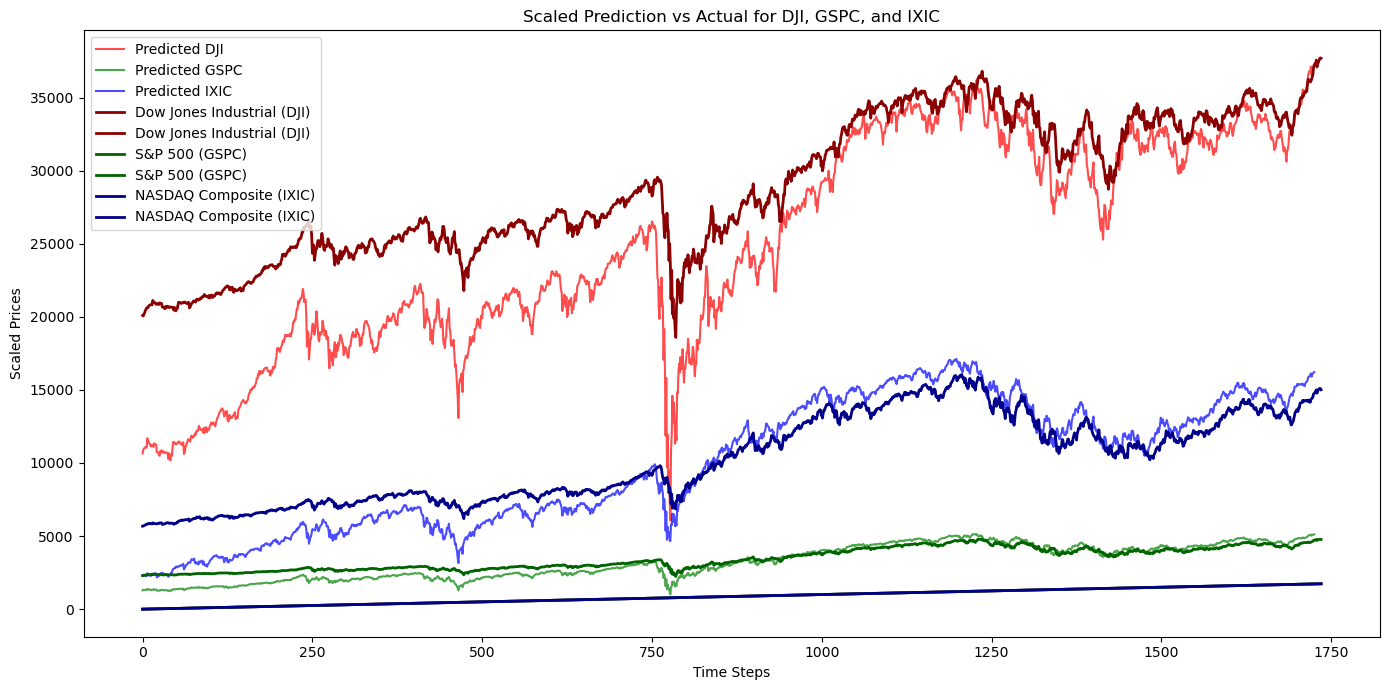

In [407]:
predicted_dji = predicted_seq_DJI.ravel()
actual_dji = (data['DJI'])
predicted_gspc = predicted_seq_GSPC.ravel()
actual_gspc = (data['GSPC'])
predicted_ixic = predicted_seq_IXIC.ravel()
actual_ixic = (data['IXIC'])

temp = []

def scale_predictions(predicted, actual):
    predicted_np = predicted.cpu().detach().numpy() if isinstance(predicted, torch.Tensor) else predicted
    actual_np = actual.cpu().detach().numpy() if isinstance(actual, torch.Tensor) else actual
    
    range_predicted = predicted_np.max() - predicted_np.min()
    range_actual = actual_np.max() - actual_np.min()
    scaled_range = (predicted_np - predicted_np.min()) / range_predicted
    scaled_predictions = scaled_range * range_actual + actual_np.min()
    
    offset = actual_np[0] - scaled_predictions[0]
    scaled_predictions += offset

    return scaled_predictions

scaled_predicted_dji = scale_predictions(predicted_dji, data['DJI'])
scaled_predicted_gspc = scale_predictions(predicted_gspc, data['GSPC'])
scaled_predicted_ixic = scale_predictions(predicted_ixic, data['IXIC'])

# Now plot
plt.figure(figsize=(14, 7))

plt.plot(scaled_predicted_dji, color='red', label='Predicted DJI', alpha=0.7)

plt.plot(scaled_predicted_gspc, color='green', label='Predicted GSPC', alpha=0.7)

plt.plot(scaled_predicted_ixic, color='blue', label='Predicted IXIC', alpha=0.7)
plt.plot(condense(actual_dji), label='Dow Jones Industrial (DJI)', color='darkred', linewidth=2)
plt.plot(condense(actual_gspc), label='S&P 500 (GSPC)', color='darkgreen', linewidth=2)
plt.plot(condense(actual_ixic), label='NASDAQ Composite (IXIC)', color='darkblue', linewidth=2)

plt.title('Scaled Prediction vs Actual for DJI, GSPC, and IXIC')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Prices')

plt.legend()
plt.tight_layout()
plt.show()

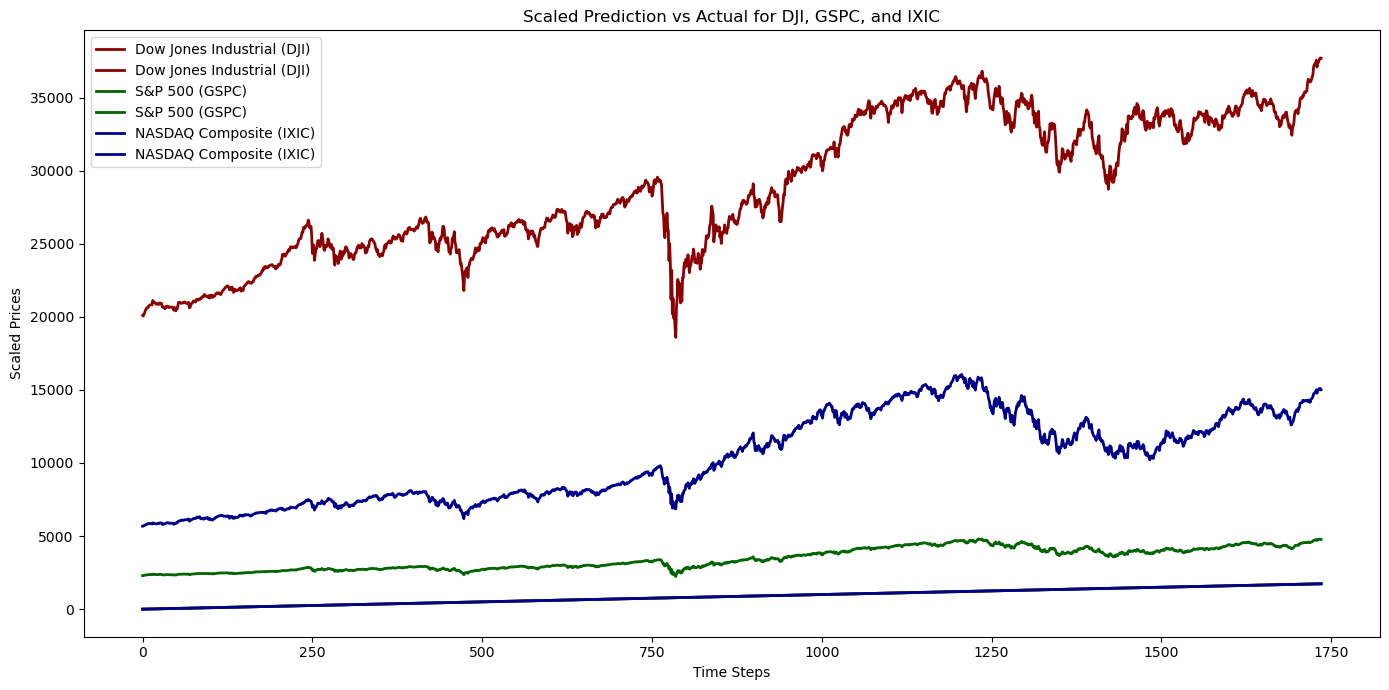

In [400]:
plt.figure(figsize=(14, 7))
plt.plot(condense(actual_dji), label='Dow Jones Industrial (DJI)', color='darkred', linewidth=2)
plt.plot(condense(actual_gspc), label='S&P 500 (GSPC)', color='darkgreen', linewidth=2)
plt.plot(condense(actual_ixic), label='NASDAQ Composite (IXIC)', color='darkblue', linewidth=2)
plt.title('Scaled Prediction vs Actual for DJI, GSPC, and IXIC')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Prices')

plt.legend()
plt.tight_layout()
plt.show()